# Simpel text classification using BERT

--> I used the code from this YT video: https://youtu.be/8yrD0hR8OY8?si=l-WNmVNs388TAlXe

### 0.1 Install libraries

In [2]:
# ! pip install --upgrade pip

# ! pip install transformers
# ! pip install datasets
# ! pip install pandas
# ! pip install evaluate
# ! pip install tf-keras
# ! pip install transformers
# ! pip install tensorflow
# ! pip install torch
# ! pip install openpyxl
# ! pip install scikit-learn
# ! pip install transformers[torch]
# ! pip install 'accelerate>=0.26.0
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
# ! pip install seaborn
# ! pip install matplotlib.pyplot

### 0.2 GPU setup

In [3]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1. Configuration

In [4]:
data_path = r"C:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-06-27 - labeled data_nonsig-with-pvalue/2025-06-28_labeled_data.xlsx"
text_column_name = "expanded"
label_column_name = "label_strict"

model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2
num_labels = 2

## 2. Read and prepare dataset

In [5]:
import pandas as pd

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA or -99
df = df[~df['label'].isna() & (df['label'] != -99)]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance the dataset: all 1s and an equal number of random 0s
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0].sample(n=len(ones), random_state=42)
df = pd.concat([ones, zeros]).sample(frac=1, random_state=42).reset_index(drop=True)

# Show head
df.head()

,text,label
0,Change-detection RTs in Experiment 1 were not ...,1
1,"However, there was no difference between the a...",1
2,There was no significant interaction between p...,0
3,The overall interaction effect of Sex Ratio Ã—...,0
4,We also examined whether individual difference...,0


### 2.1 Create Train/Test set

In [6]:
from sklearn.model_selection import train_test_split

# Separate by label
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0]

# Split each class into train/test
ones_train, ones_test = train_test_split(ones, test_size=test_size, random_state=42)
zeros_train, zeros_test = train_test_split(zeros, test_size=test_size, random_state=42)

# Combine to make balanced train/test sets
df_train = pd.concat([ones_train, zeros_train]).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat([ones_test, zeros_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Header of the Training set:

In [7]:
df_train.head()

,text,label
0,"Most importantly, however, the baseline-to-pea...",1
1,Cortisol concentrations were comparable at bas...,1
2,The main effect of workload was not significan...,0
3,Analyzing men and women separately revealed a ...,0
4,"Moreover, using markers of higher-quality list...",0


In [8]:
# Check label balance in training set
df_train['label'].value_counts()

label
1    112
0    112
Name: count, dtype: int64

Header of the Test set:

In [9]:
df_test.head()

,text,label
0,The response latencies of the low-AQ and high-...,1
1,Risk taking did not differ between participant...,1
2,Although the PTSD group showed a significant f...,0
3,Participants of the stress groups (vs. control...,1
4,There was no main effect of channel-group late...,1


In [10]:
# Check label balance in test set
df_test['label'].value_counts()

label
1    28
0    28
Name: count, dtype: int64

### 2.2 Tokenize 'text'

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=350)

tokenized_train = train_dataset.map(preprocess_function, batched=True)

tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 56/56 [00:00<00:00, 3314.91 examples/s]


#### 2.2.1 Comparing tokenized and untokenized statements

In [ ]:
# Collect comparison data for the first 20 samples (adjust as needed)
comparison = []
for i in range(224):
    original = train_dataset[i]['text']
    input_ids = tokenized_train[i]['input_ids']
    decoded = tokenizer.decode(input_ids, skip_special_tokens=True)
    comparison.append({
        "original_text": original,
        "tokenized_ids": input_ids,
        "decoded_text": decoded
    })

# Create DataFrame
df_comparison = pd.DataFrame(comparison)

# Save to CSV
# df_comparison.to_csv("tokenization_comparison.csv", index=False)
# print("Saved as tokenization_comparison.csv")

Saved as tokenization_comparison.csv


## 3. Regular BERT

### 3.1 Initializing regular BERT

In [13]:
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [16]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_22156\2814964137.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [17]:
trainer_bert.train()

Step,Training Loss
28,0.750200
56,0.731000
84,0.709500
112,0.719300
140,0.705300


TrainOutput(global_step=140, training_loss=0.7230582645961217, metrics={'train_runtime': 79.4569, 'train_samples_per_second': 14.096, 'train_steps_per_second': 1.762, 'total_flos': 159428855107200.0, 'train_loss': 0.7230582645961217, 'epoch': 5.0})

#### 3.2.1 Save last model

In [ ]:
# trainer_bert.save_model('bert_model')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [18]:
from sklearn.metrics import classification_report

preds = trainer_bert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.50      1.00      0.67       112

    accuracy                           0.50       224
   macro avg       0.25      0.50      0.33       224
weighted avg       0.25      0.50      0.33       224



c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### 3.3.2 Predict test data

In [19]:
preds = trainer_bert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.50      1.00      0.67        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### 3.3.3 4.3.3 Confusion-Matrix for test data

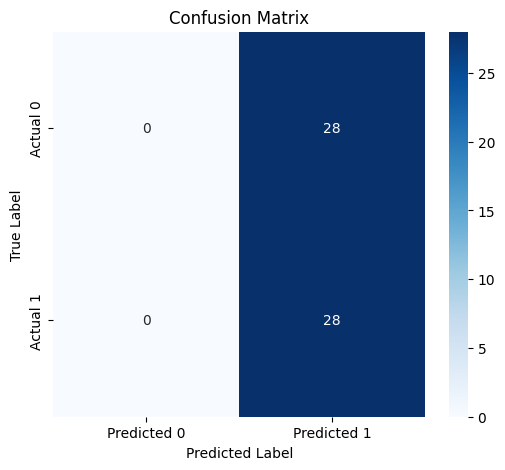

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
! pip freeze > "C:/Users/Raphael/Documents\GitHub/nonsig-master-thesis/notebooks/python/requirements.txt"

#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [ ]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [ ]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 28)


,text
0,The response latencies of the low-AQ and high-...
1,Risk taking did not differ between participant...
2,Participants of the stress groups (vs. control...
3,There was no main effect of channel-group late...
4,"Distance, Ï‡ 2 (1, N = 32) = 1.52, p = .217, d..."
5,Consistent with study hypotheses emphasizing t...
6,There was a significant effect of feeling smal...
7,Paired t tests showed that only for the neutra...
8,The results indicate that both participants in...
9,"For relative changes in pupil size, we obtaine..."


In [ ]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0): None


In [ ]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 28)


,text
0,Although the PTSD group showed a significant f...
1,"Overall, RT was on average slower when sounds ..."
2,"We found a significant main effect of outcome,..."
3,The percentage of children who waited for the ...
4,Results revealed no significant relationship b...
5,"Conversely, the interaction between KoR and SO..."
6,Participants in the ultimatum game were nonsig...
7,"The dyslexia (M = .87, SD = .05) and control (..."
8,"For the recognition data, the NHST analysis sh..."
9,"In the current meta-analysis, however, there w..."


In [ ]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1): None


## 4. SciBERT

### 4.1 Initializing SciBERT

In [ ]:
from transformers import AutoModelForSequenceClassification

model_scibert = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Training SciBERT

In [ ]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_scibert = Trainer(
    model=model_scibert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_20916\2163559050.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_scibert = Trainer(


In [ ]:
trainer_scibert.train()

Step,Training Loss
28,0.798900
56,0.731900
84,0.712100
112,0.701600
140,0.710500


TrainOutput(global_step=140, training_loss=0.7309976305280413, metrics={'train_runtime': 52.8054, 'train_samples_per_second': 21.21, 'train_steps_per_second': 2.651, 'total_flos': 159428855107200.0, 'train_loss': 0.7309976305280413, 'epoch': 5.0})

#### 4.2.1 Save last model

In [ ]:
# trainer_scibert.save_model('scibert_model')

### 4.3 Evaluate model

#### 4.3.1 Predict training data

In [ ]:
from sklearn.metrics import classification_report

preds = trainer_scibert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.50      1.00      0.67       112

    accuracy                           0.50       224
   macro avg       0.25      0.50      0.33       224
weighted avg       0.25      0.50      0.33       224



c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetr

#### 4.3.2 Predict test data

In [ ]:
preds = trainer_scibert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.50      1.00      0.67        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetr

#### 4.3.3 Confusion-Matrix for test data

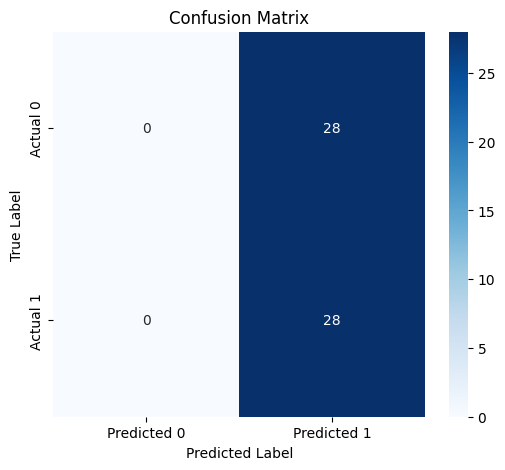

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 4.3.4 List of statements per category (TP, TN, FP, FN)

In [ ]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [ ]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 28)


,text
0,The response latencies of the low-AQ and high-...
1,Risk taking did not differ between participant...
2,Participants of the stress groups (vs. control...
3,There was no main effect of channel-group late...
4,"Distance, Ï‡ 2 (1, N = 32) = 1.52, p = .217, d..."
5,Consistent with study hypotheses emphasizing t...
6,There was a significant effect of feeling smal...
7,Paired t tests showed that only for the neutra...
8,The results indicate that both participants in...
9,"For relative changes in pupil size, we obtaine..."


In [ ]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0): None


In [ ]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 28)


,text
0,Although the PTSD group showed a significant f...
1,"Overall, RT was on average slower when sounds ..."
2,"We found a significant main effect of outcome,..."
3,The percentage of children who waited for the ...
4,Results revealed no significant relationship b...
5,"Conversely, the interaction between KoR and SO..."
6,Participants in the ultimatum game were nonsig...
7,"The dyslexia (M = .87, SD = .05) and control (..."
8,"For the recognition data, the NHST analysis sh..."
9,"In the current meta-analysis, however, there w..."


In [ ]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1): None


## 5. PubMedBERT

### 5.1 Initializing PubMedBERT

In [ ]:
from transformers import AutoModelForSequenceClassification

model_pubmedbert = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2 Training PubMedBERT

In [ ]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_pubmedbert = Trainer(
    model=model_pubmedbert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_20916\3303321629.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmedbert = Trainer(


In [ ]:
trainer_pubmedbert.train()

Step,Training Loss
28,0.808300
56,0.766300
84,0.712500
112,0.705800
140,0.706700


TrainOutput(global_step=140, training_loss=0.7399235589163644, metrics={'train_runtime': 54.5713, 'train_samples_per_second': 20.524, 'train_steps_per_second': 2.565, 'total_flos': 159428855107200.0, 'train_loss': 0.7399235589163644, 'epoch': 5.0})

#### 5.2.1 Save last model

In [ ]:
# trainer_pubmedbert.save_model('pubmedbert_model')

### 5.3 Evaluate model

#### 5.3.1 Predict training data

In [ ]:
from sklearn.metrics import classification_report

preds = trainer_pubmedbert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.50      1.00      0.67       112

    accuracy                           0.50       224
   macro avg       0.25      0.50      0.33       224
weighted avg       0.25      0.50      0.33       224



c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetr

#### 5.3.2 Predict test data

In [ ]:
preds = trainer_pubmedbert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.50      1.00      0.67        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetr

#### 5.3.3 Confusion-Matrix for test data

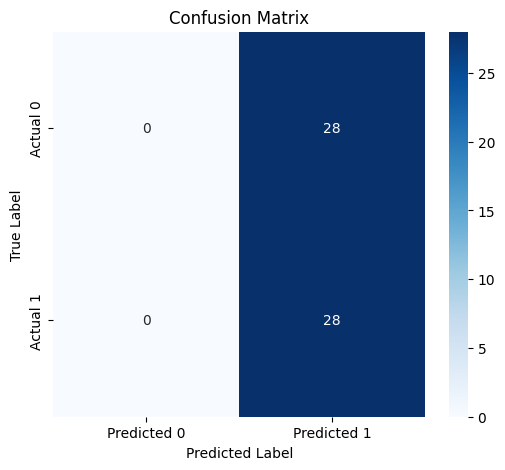

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 5.3.4 List of statements per category (TP, TN, FP, FN)

In [ ]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [ ]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 28)


,text
0,The response latencies of the low-AQ and high-...
1,Risk taking did not differ between participant...
2,Participants of the stress groups (vs. control...
3,There was no main effect of channel-group late...
4,"Distance, Ï‡ 2 (1, N = 32) = 1.52, p = .217, d..."
5,Consistent with study hypotheses emphasizing t...
6,There was a significant effect of feeling smal...
7,Paired t tests showed that only for the neutra...
8,The results indicate that both participants in...
9,"For relative changes in pupil size, we obtaine..."


In [ ]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0): None


In [ ]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 28)


,text
0,Although the PTSD group showed a significant f...
1,"Overall, RT was on average slower when sounds ..."
2,"We found a significant main effect of outcome,..."
3,The percentage of children who waited for the ...
4,Results revealed no significant relationship b...
5,"Conversely, the interaction between KoR and SO..."
6,Participants in the ultimatum game were nonsig...
7,"The dyslexia (M = .87, SD = .05) and control (..."
8,"For the recognition data, the NHST analysis sh..."
9,"In the current meta-analysis, however, there w..."


In [ ]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1): None


In [ ]:
# The end...